In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

transactions_data = pd.read_csv("lab3data.csv")

# There are many ways to do this, 2 points as long as it gives two data frames properly seperated
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
transactions_2023 = transactions_data.loc[transactions_data['date'] <= pd.to_datetime("2023-12-31")]
transactions_2024 = transactions_data.loc[transactions_data['date'] > pd.to_datetime("2023-12-31")]

transactions_2023.head()

,Unnamed: 0,customer_id,date,value,age,sex
0,2172,734,2023-01-01,108.968098,42,F
1,3430,309,2023-01-01,102.779557,28,M
2,3332,911,2023-01-01,191.300291,37,M
3,42,633,2023-01-01,106.296758,22,M
4,1275,1187,2023-01-01,104.904317,28,M


In [148]:
# One point for grouping
customer_groups_2023 = transactions_2023.groupby("customer_id")

# Two points for aggregating. Could use the .agg() function or calculate columns individually
customers_2023 = customer_groups_2023.agg({"age": "first", # Could also use mode
                                           "sex": "first",
                                           "date": len, # Can use any column to get length
                                           "value": "sum"})
customers_2023.rename(columns={"date": "count"}, inplace=True) # Renaming isn't necessary, but helpful
customers_2023

# One point for repeating the same process with 2024 data
customers_2024 = transactions_2024.groupby("customer_id").agg({"age": "first", # Could also use mode
                                                                "sex": "first",
                                                                "date": len, # Can use any column to get length
                                                                "value": "sum"})
customers_2024.rename(columns={"date": "count"}, inplace=True) # Renaming isn't necessary, but helpful

In [149]:
# Must use a left or outer join or data will be lost
# This is because some customers in 2023 don't make purchases in 2024
# 1 point for the join
customers_joined = pd.merge(customers_2023, customers_2024, 
                            left_index=True, right_index=True, 
                            suffixes = ("_2023", "_2024"), # suffixes aren't needed but helpful
                            how='left') 

# 1 point for filling purchases and value with zeros
customers_joined['count_2024'].fillna(0, inplace=True)
customers_joined['value_2024'].fillna(0, inplace=True)

# 1 point for filling in age and sex based on 2023 data
# There can be several ways of doing this, any are okay
customers_joined['age_2024'] = customers_joined['age_2023'] + 1 # +1 not needed for the mark but makes sense logically
customers_joined['sex_2024'] = customers_joined['sex_2023']

customers_joined.head()

,age_2023,sex_2023,count_2023,value_2023,age_2024,sex_2024,count_2024,value_2024
customer_id,,,,,,,,
0,28,M,4,522.486083,29,M,0.0,0.000000
1,20,F,3,274.032424,21,F,0.0,0.000000
2,54,M,5,544.359683,55,M,1.0,172.876809
3,33,M,2,342.280550,34,M,0.0,0.000000
4,30,F,2,199.699154,31,F,0.0,0.000000


In [150]:
(customers_joined['count_2024'] == 0).sum()

819

In [151]:
import statsmodels.gam.api as smg
import statsmodels.api as sm
# One point for specify any B-Spline
# Additional point for getting all three
bs = smg.BSplines(x=customers_joined[['age_2023','count_2023','value_2023']],
                  df = [4,5,5], # df and degree can have any value
                  degree = [3,3,3])

# One point for getting dummy variables
exog = pd.get_dummies(customers_joined['sex_2023'], drop_first=True)
exog = sm.add_constant(exog)

# One point for setting up the GAM
# One point for choosing the Binomial family
gam = smg.GLMGam(endog = customers_joined['count_2024']>0, 
                 exog = exog, # Can use 2023 or 2024 values here
                 smoother=bs,
                 family=sm.families.Binomial())

# One point for fitting the GAM
res = gam.fit(maxiter=5000)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             count_2024   No. Observations:                 1447
Model:                         GLMGam   Df Residuals:                  1434.00
Model Family:                Binomial   Df Model:                        12.00
Link Function:                  Logit   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -751.00
Date:                Sun, 03 Mar 2024   Deviance:                       1502.0
Time:                        11:32:34   Pearson chi2:                 1.53e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2817
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.3862      1.096     -4.001      0.000      -6.535      -2.238
M                -0.3516      0.126     -2.791      0.005      -0.599      -0.105
age_2023_s0       1.8518      1.186      1.561      0.119      -0.473       4.177
age_2023_s1      -2.8629      1.797     -1.593      0.111      -6.386       0.660
age_2023_s2      -0.0543      3.154     -0.017      0.986      -6.236       6.127
count_2023_s0     3.4678      1.413      2.455      0.014       0.699       6.237
count_2023_s1     5.0508      1.447      3.490      0.000       2.214       7.888
count_2023_s2    -0.0944      2.196     -0.043      0.966      -4.398       4.209
count_2023_s3     9.7572      3.229      3.021      0.003       3.428      16.087
value_2023_s0    -2.0844      1.881     -1.108      0.268      -5.772       1.603
value_2023_s1     4.7262      1.614      2.929      0.003       1.564       7.889
value_2023_s2    -0.4372      2.283     -0.191      0.848      -4.912       4.037
value_2023_s3     1.0009      2.285      0.438      0.661      -3.478       5.480
=================================================================================
"""

In [152]:
# One point for the correct endogenous variable
# One point for any continuous family (or undefined for Gaussian)
gam = smg.GLMGam(endog = customers_joined['value_2024'], 
                 exog = exog, # Can use 2023 or 2024 values here
                 smoother=bs,
                 family=sm.families.Gaussian())

# One point for fitting the GAM
res = gam.fit(maxiter=5000)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             value_2024   No. Observations:                 1447
Model:                         GLMGam   Df Residuals:                     1434
Model Family:                Gaussian   Df Model:                        12.00
Link Function:               Identity   Scale:                          13956.
Method:                         PIRLS   Log-Likelihood:                -8951.5
Date:                Sun, 03 Mar 2024   Deviance:                   2.0012e+07
Time:                        11:32:34   Pearson chi2:                 2.00e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2110
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            25.6400     25.410      1.009      0.313     -24.162      75.442
M               -19.6994      6.233     -3.161      0.002     -31.915      -7.484
age_2023_s0      41.4050     56.969      0.727      0.467     -70.252     153.062
age_2023_s1    -128.1488     78.407     -1.634      0.102    -281.823      25.525
age_2023_s2      -4.2183    116.029     -0.036      0.971    -231.630     223.194
count_2023_s0     1.8889     25.864      0.073      0.942     -48.803      52.581
count_2023_s1   148.0700     59.691      2.481      0.013      31.079     265.061
count_2023_s2  -103.2536     76.698     -1.346      0.178    -253.579      47.071
count_2023_s3   310.9588    117.921      2.637      0.008      79.838     542.080
value_2023_s0   -59.1380     44.852     -1.319      0.187    -147.046      28.770
value_2023_s1   210.9222     62.709      3.363      0.001      88.014     333.830
value_2023_s2    -6.3928     80.748     -0.079      0.937    -164.656     151.871
value_2023_s3     3.1626    104.284      0.030      0.976    -201.230     207.556
=================================================================================
"""

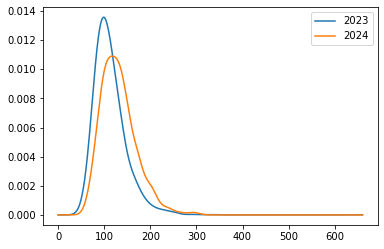

In [153]:
from sklearn.neighbors import KernelDensity

# One point for 2024 fit
kde_value_2023 = KernelDensity(bandwidth=10)
kde_value_2023.fit(transactions_2023['value'].values.reshape(-1,1))

# One point for 2024 fit
kde_value_2024 = KernelDensity(bandwidth=10)
kde_value_2024.fit(transactions_2024['value'].values.reshape(-1,1))

# One point for 2025 fit
xr = np.linspace(0, max(transactions_2023['value'].max(), transactions_2024['value'].max()), 1000).reshape(-1,1)
plt.plot(xr, np.exp(kde_value_2023.score_samples(xr)), label='2023')
plt.plot(xr, np.exp(kde_value_2024.score_samples(xr)), label='2024')
plt.legend()
plt.show()

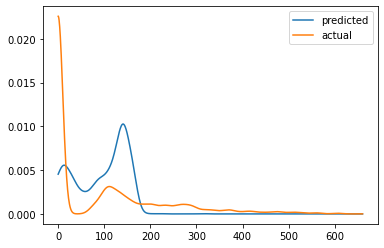

In [159]:
# One point for fitting to customer value
customer_value_2024 = KernelDensity(bandwidth=10)
customer_value_2024.fit(customers_joined['value_2024'].values.reshape(-1,1))

# One point for fitting to predictions
customer_value_pred = KernelDensity(bandwidth=10)
customer_value_pred.fit(res.predict().reshape(-1,1))

# One point for plotting with labels
plt.plot(xr, np.exp(customer_value_pred.score_samples(xr)), label='predicted')
plt.plot(xr, np.exp(customer_value_2024.score_samples(xr)), label='actual')
plt.legend()
plt.show()